In [52]:
import pyspark
import pyspark.sql.functions
import pyspark.sql.functions as func
from pyspark.sql import *
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql import functions as f
from pyspark.sql.functions import when

from pandas import Timestamp


import time
import datetime
from datetime import datetime as dt, timedelta

import matplotlib.pyplot as plt

import pandas as pd
from haversine import haversine, Unit

In [4]:
spark = SparkSession.builder.master("local[*]").appName("ford_go_bike").getOrCreate()

In [5]:
spark

In [42]:
df = spark.read.option("header", "true").format("csv").load("2017-fordgobike-tripdata.csv")

In [12]:
df.printSchema()

root
 |-- duration_sec: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)



In [14]:
pDf = pd.read_csv("2017-fordgobike-tripdata.csv")

In [15]:
pDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             519700 non-null  int64  
 1   start_time               519700 non-null  object 
 2   end_time                 519700 non-null  object 
 3   start_station_id         519700 non-null  int64  
 4   start_station_name       519700 non-null  object 
 5   start_station_latitude   519700 non-null  float64
 6   start_station_longitude  519700 non-null  float64
 7   end_station_id           519700 non-null  int64  
 8   end_station_name         519700 non-null  object 
 9   end_station_latitude     519700 non-null  float64
 10  end_station_longitude    519700 non-null  float64
 11  bike_id                  519700 non-null  int64  
 12  user_type                519700 non-null  object 
 13  member_birth_year        453159 non-null  float64
 14  memb

In [16]:
pDf["distance"] = pDf.apply(lambda x: haversine((x["start_station_latitude"], x["start_station_longitude"]), (x["end_station_latitude"], x["end_station_longitude"])),axis=1)

In [17]:
pDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             519700 non-null  int64  
 1   start_time               519700 non-null  object 
 2   end_time                 519700 non-null  object 
 3   start_station_id         519700 non-null  int64  
 4   start_station_name       519700 non-null  object 
 5   start_station_latitude   519700 non-null  float64
 6   start_station_longitude  519700 non-null  float64
 7   end_station_id           519700 non-null  int64  
 8   end_station_name         519700 non-null  object 
 9   end_station_latitude     519700 non-null  float64
 10  end_station_longitude    519700 non-null  float64
 11  bike_id                  519700 non-null  int64  
 12  user_type                519700 non-null  object 
 13  member_birth_year        453159 non-null  float64
 14  memb

In [18]:
pDf

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,distance
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,0.942932
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,3.069731
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,0.000000
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,1.046624
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,0.636340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519695,435,2017-06-28 10:00:54.5280,2017-06-28 10:08:10.4380,81,Berry St at 4th St,37.775880,-122.393170,45,5th St at Howard St,37.781752,-122.405127,400,Subscriber,1991.0,Male,1.237187
519696,431,2017-06-28 09:56:39.6310,2017-06-28 10:03:51.0900,66,3rd St at Townsend St,37.778742,-122.392741,321,5th at Folsom,37.780146,-122.403071,316,Subscriber,1973.0,Male,0.921190
519697,424,2017-06-28 09:47:36.3470,2017-06-28 09:54:41.1870,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,48,2nd St at S Park St,37.782411,-122.392706,240,Subscriber,1985.0,Female,1.072757
519698,366,2017-06-28 09:47:41.6640,2017-06-28 09:53:47.7150,58,Market St at 10th St,37.776619,-122.417385,59,S Van Ness Ave at Market St,37.774814,-122.418954,669,Subscriber,1981.0,Male,0.243515


In [19]:
pDf['start_time'] = pd.to_datetime(pDf['start_time'])

In [20]:
pDf['end_time'] = pd.to_datetime(pDf['end_time'])

In [21]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")

In [23]:
pDf.to_csv('forgobike&distances.csv')

In [228]:
df = spark.read.format("csv").option("header", "true").load("forgobike&distances.csv")

In [229]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- duration_sec: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- distance: string (nullable = true)



In [230]:
df = df.withColumnRenamed("_c0", "index")

In [28]:
df.select(df.columns[:5]).show()

+-----+------------+--------------------+--------------------+----------------+
|index|duration_sec|          start_time|            end_time|start_station_id|
+-----+------------+--------------------+--------------------+----------------+
|    0|       80110|2017-12-31 16:57:...|2018-01-01 15:12:...|              74|
|    1|       78800|2017-12-31 15:56:...|2018-01-01 13:49:...|             284|
|    2|       45768|2017-12-31 22:45:...|2018-01-01 11:28:...|             245|
|    3|       62172|2017-12-31 17:31:...|2018-01-01 10:47:...|              60|
|    4|       43603|2017-12-31 14:23:...|2018-01-01 02:29:...|             239|
|    5|        9226|2017-12-31 22:51:...|2018-01-01 01:24:...|              30|
|    6|        4507|2017-12-31 23:49:...|2018-01-01 01:04:...|             259|
|    7|        4334|2017-12-31 23:46:...|2018-01-01 00:58:...|             284|
|    8|        4150|2017-12-31 23:37:...|2018-01-01 00:46:...|              20|
|    9|        4238|2017-12-31 23:35:...

In [29]:
df = df.withColumn("distance", col("distance").cast("float"))

# Calculate the total distance for each bike and list the top 10

In [30]:
df.groupby('bike_id').agg({'distance':'sum'}).orderBy('sum(distance)', ascending = False).show(10)

+-------+-----------------+
|bike_id|    sum(distance)|
+-------+-----------------+
|     68|743.3694912344217|
|   2178|721.1822336316109|
|    256|671.9161504805088|
|    235|670.1619913876057|
|   2049|656.8280823230743|
|    441|656.6422760337591|
|   2226|647.8232692182064|
|    796|646.8677228093147|
|    190|640.2941762208939|
|   2365|  639.41270147264|
+-------+-----------------+
only showing top 10 rows



In [31]:
df.createOrReplaceTempView("df")

# Calculate the number of trips for each start station list top 10 and find the ratio of using as male or female

In [32]:
start_stations = []
top_stations = spark.sql("SELECT start_station_id, COUNT(ALL start_station_id) FROM df GROUP BY start_station_id ORDER BY count(start_station_id) desc LIMIT 10").collect()
for i in top_stations:
    start_stations.append(float(i[0]))
start_stations

[15.0, 6.0, 30.0, 67.0, 58.0, 21.0, 81.0, 3.0, 22.0, 16.0]

In [33]:
pDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             519700 non-null  int64         
 1   start_time               519700 non-null  datetime64[ns]
 2   end_time                 519700 non-null  datetime64[ns]
 3   start_station_id         519700 non-null  int64         
 4   start_station_name       519700 non-null  object        
 5   start_station_latitude   519700 non-null  float64       
 6   start_station_longitude  519700 non-null  float64       
 7   end_station_id           519700 non-null  int64         
 8   end_station_name         519700 non-null  object        
 9   end_station_latitude     519700 non-null  float64       
 10  end_station_longitude    519700 non-null  float64       
 11  bike_id                  519700 non-null  int64         
 12  user_type       

In [34]:
pDf['member_gender'][pDf["member_gender"] == 'Male'] = 1

C:\Users\mkaya\AppData\Local\Temp\ipykernel_1692\4292331174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pDf['member_gender'][pDf["member_gender"] == 'Male'] = 1


In [35]:
pDf['member_gender'][pDf['member_gender'] == 'Female'] = 0

C:\Users\mkaya\AppData\Local\Temp\ipykernel_1692\2226487565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pDf['member_gender'][pDf['member_gender'] == 'Female'] = 0


In [36]:
pDf['member_gender'][(pDf['member_gender'] != 1) & (pDf['member_gender'] != 0)] = None

C:\Users\mkaya\AppData\Local\Temp\ipykernel_1692\893596964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pDf['member_gender'][(pDf['member_gender'] != 1) & (pDf['member_gender'] != 0)] = None


In [37]:
pDf['member_gender'].unique()

array([1, 0, None], dtype=object)

In [38]:
pDf['member_gender'] = pDf['member_gender'].astype('float64')

In [39]:
pDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             519700 non-null  int64         
 1   start_time               519700 non-null  datetime64[ns]
 2   end_time                 519700 non-null  datetime64[ns]
 3   start_station_id         519700 non-null  int64         
 4   start_station_name       519700 non-null  object        
 5   start_station_latitude   519700 non-null  float64       
 6   start_station_longitude  519700 non-null  float64       
 7   end_station_id           519700 non-null  int64         
 8   end_station_name         519700 non-null  object        
 9   end_station_latitude     519700 non-null  float64       
 10  end_station_longitude    519700 non-null  float64       
 11  bike_id                  519700 non-null  int64         
 12  user_type       

In [40]:
top_trips = pDf.set_index('start_station_id').loc[start_stations]
top_trips.dropna(how='any', axis=0, inplace=True)
top_trips['male/female_ratio'] = pDf.set_index('start_station_id').loc[start_stations].groupby('start_station_id').sum()['member_gender'] / (pDf.set_index('start_station_id').loc[start_stations].groupby('start_station_id').count()['member_gender'] - pDf.set_index('start_station_id').loc[start_stations].groupby('start_station_id').sum()['member_gender'])
top_trips

,duration_sec,start_time,end_time,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,distance,male/female_ratio
start_station_id,,,,,,,,,,,,,,,,
15,814,2017-12-31 18:25:37.866,2017-12-31 18:39:12.172,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,90,Townsend St at 7th St,37.771058,-122.402717,1518,Subscriber,1982.0,1.0,2.807366,3.045761
15,794,2017-12-31 17:15:08.680,2017-12-31 17:28:23.372,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,6,The Embarcadero at Sansome St,37.804770,-122.403234,3047,Customer,1994.0,1.0,1.310347,3.045761
15,904,2017-12-31 17:00:43.128,2017-12-31 17:15:47.797,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,66,3rd St at Townsend St,37.778742,-122.392741,2328,Subscriber,1986.0,1.0,1.855895,3.045761
15,839,2017-12-31 16:59:04.503,2017-12-31 17:13:04.356,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,365,Customer,1994.0,0.0,1.670281,3.045761
15,808,2017-12-31 16:59:00.411,2017-12-31 17:12:28.996,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,2848,Customer,1991.0,1.0,1.670281,3.045761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,804,2017-07-10 18:28:06.560,2017-07-10 18:41:31.009,Steuart St at Market St,37.794130,-122.394430,81,Berry St at 4th St,37.775880,-122.393170,73,Subscriber,1981.0,1.0,2.032329,3.754023
16,263,2017-07-10 18:10:56.379,2017-07-10 18:15:20.272,Steuart St at Market St,37.794130,-122.394430,28,The Embarcadero at Bryant St,37.787168,-122.388098,871,Subscriber,1980.0,1.0,0.953356,3.754023
16,789,2017-07-10 17:47:26.048,2017-07-10 18:00:35.376,Steuart St at Market St,37.794130,-122.394430,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,360,Subscriber,1972.0,1.0,1.950909,3.754023


In [41]:
2700/3576

0.7550335570469798

# Make a comparison to find the percentage of usage for customer and subscriber

In [398]:
pDf['user_type'][pDf['user_type'] == 'Customer'].count() / pDf['user_type'][pDf['user_type'] == 'Subscriber'].count()

0.1214841265959008

# Calculate the age of all users and show the relation between the distance and the age

In [427]:
pDf.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,distance,member_age
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,1.0,No,0.544709,39.0
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No,1.743002,NaN
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,1.0,No,2.704549,51.0
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,NaN,No,0.260739,34.0
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,1.0,Yes,2.409305,49.0


In [417]:
this_year = int(pd.to_datetime('today').strftime('%Y'))
pDf['member_age'] = this_year - pDf['member_birth_year']

In [418]:
pDf.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,member_gender,distance,member_age
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000,171495.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437,0.761836,1.690661,38.193563
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689,0.425961,1.097591,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000,0.000000,0.000000,22.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000,1.000000,0.910957,31.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000,1.000000,1.430740,36.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000,1.000000,2.225690,43.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000,1.000000,69.469337,145.000000


In [419]:
pDf[pDf['member_age'] > 38].describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,member_gender,distance,member_age
count,67537.000000,67485.000000,67537.000000,67537.000000,67485.000000,67537.000000,67537.000000,67537.000000,67537.000000,65755.000000,67537.000000,67537.000000
mean,708.796053,125.374350,37.780332,-122.366824,123.005112,37.780525,-122.366485,4416.893318,1974.784459,0.791347,1.696587,48.215541
std,1530.116874,106.840291,0.069240,0.089790,106.482355,0.069075,0.089323,1705.194726,8.804900,0.406349,1.104481,8.804900
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000,0.000000,0.000000,39.000000
25%,323.000000,35.000000,37.771058,-122.412544,30.000000,37.771662,-122.411738,3498.000000,1970.000000,1.000000,0.910957,41.000000
50%,511.000000,92.000000,37.781074,-122.398436,90.000000,37.781270,-122.398279,4947.000000,1977.000000,1.000000,1.432475,46.000000
75%,796.000000,187.000000,37.795393,-122.389970,186.000000,37.795393,-122.389970,5493.000000,1982.000000,1.000000,2.228579,53.000000
max,84548.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,1984.000000,1.000000,11.707458,145.000000


In [420]:
pDf[pDf['member_age'] < 38].describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,member_gender,distance,member_age
count,100582.000000,100444.000000,100582.000000,100582.000000,100444.000000,100582.000000,100582.000000,100582.000000,100582.00000,98832.000000,100582.000000,100582.00000
mean,700.903551,148.901268,37.763700,-122.339648,146.430061,37.763871,-122.339202,4524.660416,1991.52229,0.742958,1.678342,31.47771
std,1721.150046,114.017186,0.119138,0.134994,113.699012,0.119053,0.134545,1625.181451,3.69027,0.437005,1.073919,3.69027
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1986.00000,0.000000,0.000000,22.00000
25%,321.000000,58.000000,37.769305,-122.411738,54.000000,37.770030,-122.411403,3967.000000,1988.00000,0.000000,0.902988,29.00000
50%,508.000000,114.000000,37.780450,-122.397437,112.000000,37.780526,-122.397086,4966.000000,1991.00000,1.000000,1.413550,32.00000
75%,783.000000,246.000000,37.798572,-122.270556,245.000000,37.799953,-122.271738,5514.000000,1994.00000,1.000000,2.205631,35.00000
max,83519.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.00000,1.000000,15.673977,37.00000


In [447]:
data = pDf.groupby('member_age').mean().reset_index()

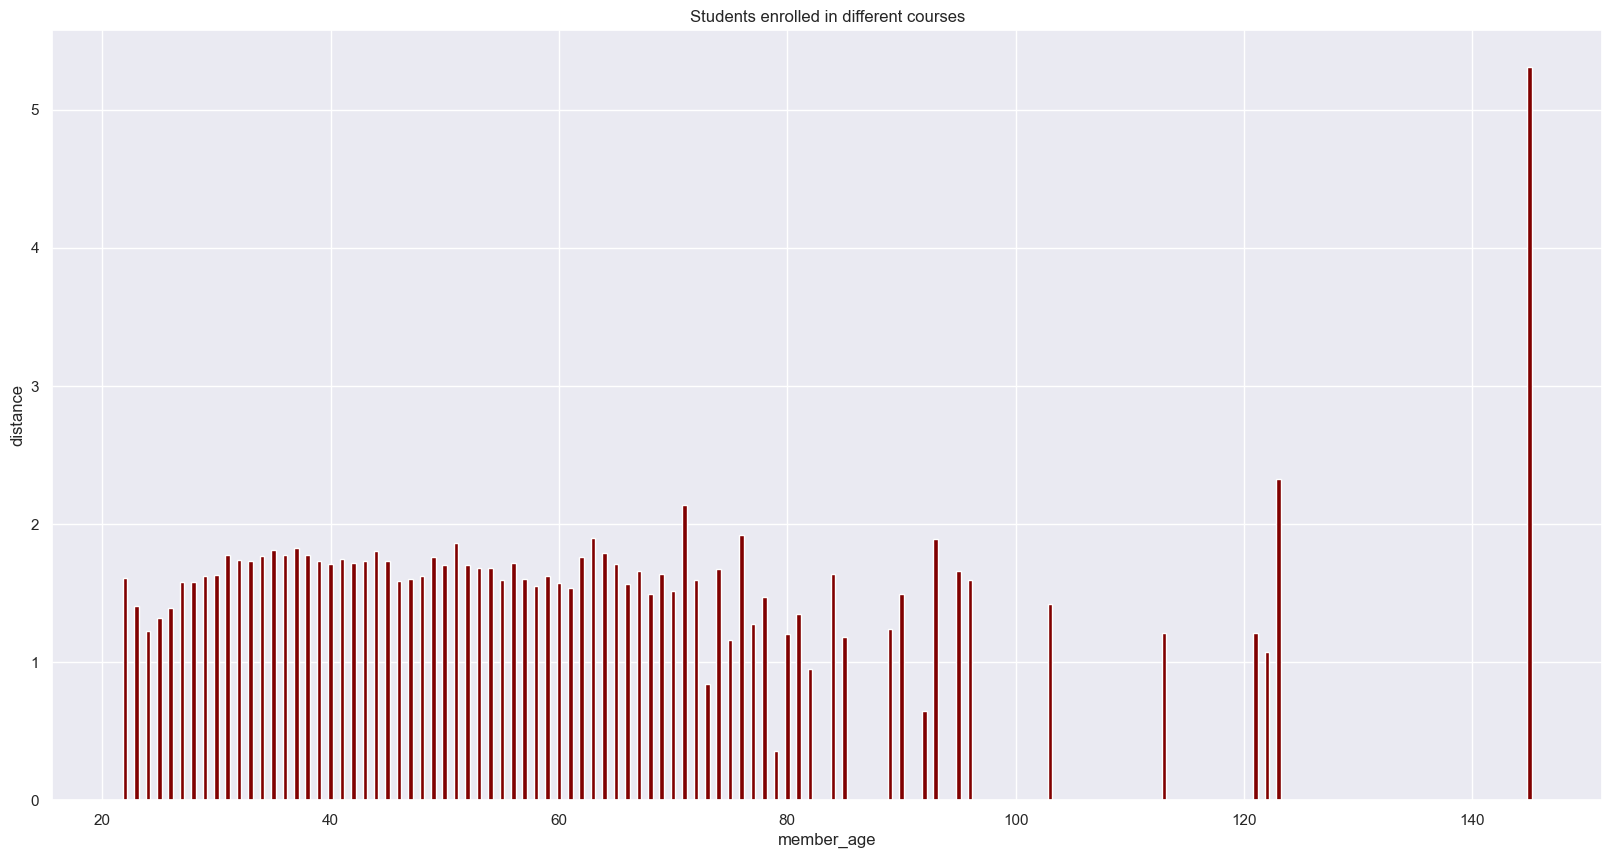

In [461]:
plt.figure(figsize = (20,10))
plt.bar(data['member_age'], data['distance'], color ='maroon',
        width = 0.4)
plt.xlabel("member_age")
plt.ylabel("distance")
plt.title("Students enrolled in different courses")
plt.show()

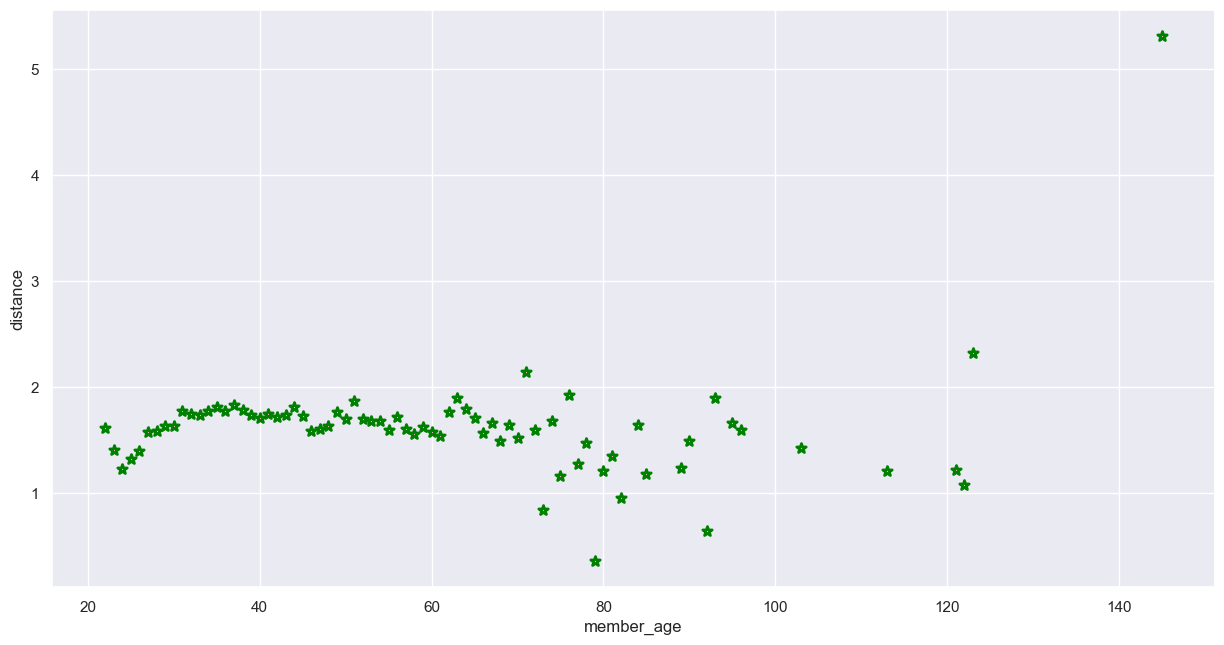

In [458]:
plt.figure(figsize=(15,7.5))
plt.scatter(data['member_age'], data['distance'], c ="pink",
            linewidths = 2,
            marker ="*",
            edgecolor ="green",
            s = 50)
plt.xlabel("member_age")
plt.ylabel("distance")
plt.show()

+------------+--------------------+--------------------+----------------+--------------------+
|duration_sec|          start_time|            end_time|start_station_id|  start_station_name|
+------------+--------------------+--------------------+----------------+--------------------+
|       52185|2019-02-28 17:32:...|2019-03-01 08:01:...|              21|Montgomery St BAR...|
|       42521|2019-02-28 18:53:...|2019-03-01 06:42:...|              23|The Embarcadero a...|
|       61854|2019-02-28 12:13:...|2019-03-01 05:24:...|              86|Market St at Dolo...|
|       36490|2019-02-28 17:54:...|2019-03-01 04:02:...|             375|Grove St at Mason...|
|        1585|2019-02-28 23:54:...|2019-03-01 00:20:...|               7| Frank H Ogawa Plaza|
|        1793|2019-02-28 23:49:...|2019-03-01 00:19:...|              93|4th St at Mission...|
|        1147|2019-02-28 23:55:...|2019-03-01 00:14:...|             300|Palm St at Willow St|
|        1615|2019-02-28 23:41:...|2019-03-01 00:0

# 1 - Calculate the total cost for all customers and all subscribers

In [42]:
df

DataFrame[index: string, duration_sec: string, start_time: string, end_time: string, start_station_id: string, start_station_name: string, start_station_latitude: string, start_station_longitude: string, end_station_id: string, end_station_name: string, end_station_latitude: string, end_station_longitude: string, bike_id: string, user_type: string, member_birth_year: string, member_gender: string, distance: float]

In [43]:
df.printSchema()

root
 |-- index: string (nullable = true)
 |-- duration_sec: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- distance: float (nullable = true)



In [83]:
from pandas import Timestamp


In [43]:
df

DataFrame[duration_sec: string, start_time: string, end_time: string, start_station_id: string, start_station_name: string, start_station_latitude: string, start_station_longitude: string, end_station_id: string, end_station_name: string, end_station_latitude: string, end_station_longitude: string, bike_id: string, user_type: string, member_birth_year: string, member_gender: string]

In [231]:
df = df.withColumn('start_time', func.to_timestamp(df['start_time'], 'yyyy-MM-dd HH:mm:ss.SSSS')).withColumn('end_time', func.to_timestamp(df['end_time'], 'yyyy-MM-dd HH:mm:ss.SSSS'))

In [232]:
df.printSchema()

root
 |-- index: string (nullable = true)
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- distance: string (nullable = true)



In [233]:
df[['start_time', 'end_time']].show()

+--------------------+--------------------+
|          start_time|            end_time|
+--------------------+--------------------+
|2017-12-31 16:57:...|2018-01-01 15:12:...|
|2017-12-31 15:56:...|2018-01-01 13:49:...|
|2017-12-31 22:45:...|2018-01-01 11:28:...|
|2017-12-31 17:31:...|2018-01-01 10:47:...|
|2017-12-31 14:23:...|2018-01-01 02:29:...|
|2017-12-31 22:51:...|2018-01-01 01:24:...|
|2017-12-31 23:49:...|2018-01-01 01:04:...|
|2017-12-31 23:46:...|2018-01-01 00:58:...|
|2017-12-31 23:37:...|2018-01-01 00:46:...|
|2017-12-31 23:35:...|2018-01-01 00:46:...|
|2017-12-31 23:46:...|2018-01-01 00:41:...|
|2017-12-31 23:48:...|2018-01-01 00:41:...|
|2017-12-31 23:52:...|2018-01-01 00:29:...|
|2017-12-31 23:52:...|2018-01-01 00:29:...|
|2017-12-31 23:35:...|2018-01-01 00:20:...|
|2017-12-31 23:53:...|2018-01-01 00:19:...|
|2017-12-31 23:54:...|2018-01-01 00:19:...|
|2017-12-31 23:55:...|2018-01-01 00:18:...|
|2017-12-31 23:52:...|2018-01-01 00:18:...|
|2017-12-31 23:46:...|2018-01-01

In [234]:
df = df.withColumn('duration',df['end_time'] - df['start_time'] )

In [235]:
df = df.withColumn('duration_in_minutes', func.round(df['duration'].cast('long') / 60 , 2))

In [236]:
df.select(['duration_in_minutes']).show()

+-------------------+
|duration_in_minutes|
+-------------------+
|            1335.17|
|            1313.33|
|              762.8|
|             1036.2|
|             726.72|
|             153.77|
|              75.12|
|              72.23|
|              69.17|
|              70.63|
|              54.87|
|              52.95|
|              36.38|
|              36.17|
|              44.95|
|              25.73|
|              24.57|
|              23.28|
|              25.53|
|              20.27|
+-------------------+
only showing top 20 rows



In [237]:
df.printSchema()

root
 |-- index: string (nullable = true)
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- duration: interval day to second (nullable = true)
 |-- duration_in_minutes: double (nullable = true)



In [238]:
df = df.drop('duration')

In [239]:
df = df.withColumn('cost',func.round( df['duration_in_minutes'].cast('float') * 0.35, 2))

In [240]:
df.select('user_type').distinct().show()

+----------+
| user_type|
+----------+
|Subscriber|
|  Customer|
+----------+



In [241]:
df.groupBy('user_type').sum().drop('sum(duration_in_minutes)').\
withColumnRenamed('sum(cost)','$ Costs').\
withColumn('$ Costs', func.round('$ Costs', 2)).show()

+----------+----------+
| user_type|   $ Costs|
+----------+----------+
|Subscriber|1683665.96|
|  Customer|1647871.42|
+----------+----------+



 # 2 - Analyze how often bikes are being rented ( morning - afternoon - evening) and at what times of day

In [183]:
df.printSchema()

root
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- duration_in_minutes: double (nullable = true)
 |-- cost: double (nullable = true)



In [218]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, date_format

In [242]:
df = df.withColumn('start_date', date_format('start_time', 'M/d/yyyy').alias('Date')).\
withColumn('start_hour', date_format('start_time', 'HH:mm:ss.SSSS').alias('Time'))

In [243]:
df = df.withColumn('time_of_the_day', when(df['start_hour'] < '12:00:00.000', 'morning').when(df['start_hour'] > '18:00:00.000', 'evening').otherwise('afternoon'))

In [244]:
df.select('start_hour', 'time_of_the_day').show()

+-------------+---------------+
|   start_hour|time_of_the_day|
+-------------+---------------+
|16:57:39.6540|      afternoon|
|15:56:34.8420|      afternoon|
|22:45:48.4110|        evening|
|17:31:10.6360|      afternoon|
|14:23:14.0010|      afternoon|
|22:51:00.9180|        evening|
|23:49:28.4220|        evening|
|23:46:37.1960|        evening|
|23:37:07.5480|        evening|
|23:35:38.1450|        evening|
|23:46:32.4030|        evening|
|23:48:11.7570|        evening|
|23:52:55.5810|        evening|
|23:52:55.9370|        evening|
|23:35:23.2220|        evening|
|23:53:38.9430|        evening|
|23:54:40.1460|        evening|
|23:55:09.6860|        evening|
|23:52:49.4970|        evening|
|23:46:33.9930|        evening|
+-------------+---------------+
only showing top 20 rows



In [245]:
df.groupBy('time_of_the_day').count().show()

+---------------+------+
|time_of_the_day| count|
+---------------+------+
|      afternoon|209620|
|        morning|195925|
|        evening|114155|
+---------------+------+



#  3 -Find if there is a relation between the time and start stations

In [247]:
df.printSchema()

root
 |-- index: string (nullable = true)
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- duration_in_minutes: double (nullable = true)
 |-- cost: double (nullable = true)
 |-- start_date: string (nullable = true)
 |-- start_hour: string (nullable = true)
 |-- time_of_the_day: string (nulla

In [284]:
df = df.withColumn('start_hour', func.to_timestamp('start_hour', 'HH:mm:ss.SSSS'))

In [285]:
df.printSchema()

root
 |-- index: string (nullable = true)
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- duration_in_minutes: double (nullable = true)
 |-- cost: double (nullable = true)
 |-- start_date: string (nullable = true)
 |-- start_hour: timestamp (nullable = true)
 |-- time_of_the_day: string (nu

In [256]:
from pyspark.sql.functions import expr

In [291]:
df.withColumn('average_hour', func.unix_timestamp(func.date_format('start_hour', 'HH:mm:ss'))) \
   .groupby('start_station_id') \
   .agg(func.from_unixtime(func.avg('start_hour'),'HH:mm:ss').alias('avg_hour')).\
show()

+----------------+--------+
|start_station_id|avg_hour|
+----------------+--------+
|             296|13:19:52|
|             125|13:21:02|
|               7|15:51:39|
|             124|14:02:15|
|             307|15:52:41|
|             205|11:31:44|
|             169|12:57:49|
|             232|13:56:28|
|              15|12:10:59|
|             282|14:45:24|
|             234|16:15:50|
|             317|12:56:59|
|             132|12:57:36|
|             154|13:23:58|
|             200|12:06:50|
|              11|14:38:12|
|             101|15:03:42|
|             279|14:50:51|
|             323|13:20:00|
|             138|12:26:39|
+----------------+--------+
only showing top 20 rows



In [293]:
idAvgTimes = df.withColumn('average_hour', func.unix_timestamp(func.date_format('start_hour', 'HH:mm:ss'))) \
   .groupby('start_station_id') \
   .agg(func.from_unixtime(func.avg('start_hour'),'HH:mm:ss').alias('avg_hour'))

In [294]:
idAvgTimes.show()

+----------------+--------+
|start_station_id|avg_hour|
+----------------+--------+
|             296|13:19:52|
|             125|13:21:02|
|               7|15:51:39|
|             124|14:02:15|
|             307|15:52:41|
|             205|11:31:44|
|             169|12:57:49|
|             232|13:56:28|
|              15|12:10:59|
|             282|14:45:24|
|             234|16:15:50|
|             317|12:56:59|
|             132|12:57:36|
|             154|13:23:58|
|             200|12:06:50|
|              11|14:38:12|
|             101|15:03:42|
|             279|14:50:51|
|             323|13:20:00|
|             138|12:26:39|
+----------------+--------+
only showing top 20 rows



In [326]:
hours = idAvgTimes.select('avg_hour').collect()
stations= idAvgTimes.select('start_station_id').collect()

In [327]:
start_stations = []
average_hours = []

In [328]:
for i in range(len(hours)):
    average_hours.append(hours[i][0][0:2])
    start_stations.append(stations[i][0])

In [420]:
len(average_hours)

272

In [419]:
len(start_stations)

272

In [346]:
DF = pd.DataFrame(zip(start_stations, average_hours))

In [347]:
DF = DF.rename(columns={0 : 'start_stations', 1:'average_hours'})

In [349]:
DF[DF['start_stations']]

,start_stations,average_hours
0,296,13
1,125,13
2,7,15
3,124,14
4,307,15
...,...,...
267,50,14
268,184,16
269,199,15
270,185,12


In [391]:
DF = DF.sort_values(by = 'start_stations')

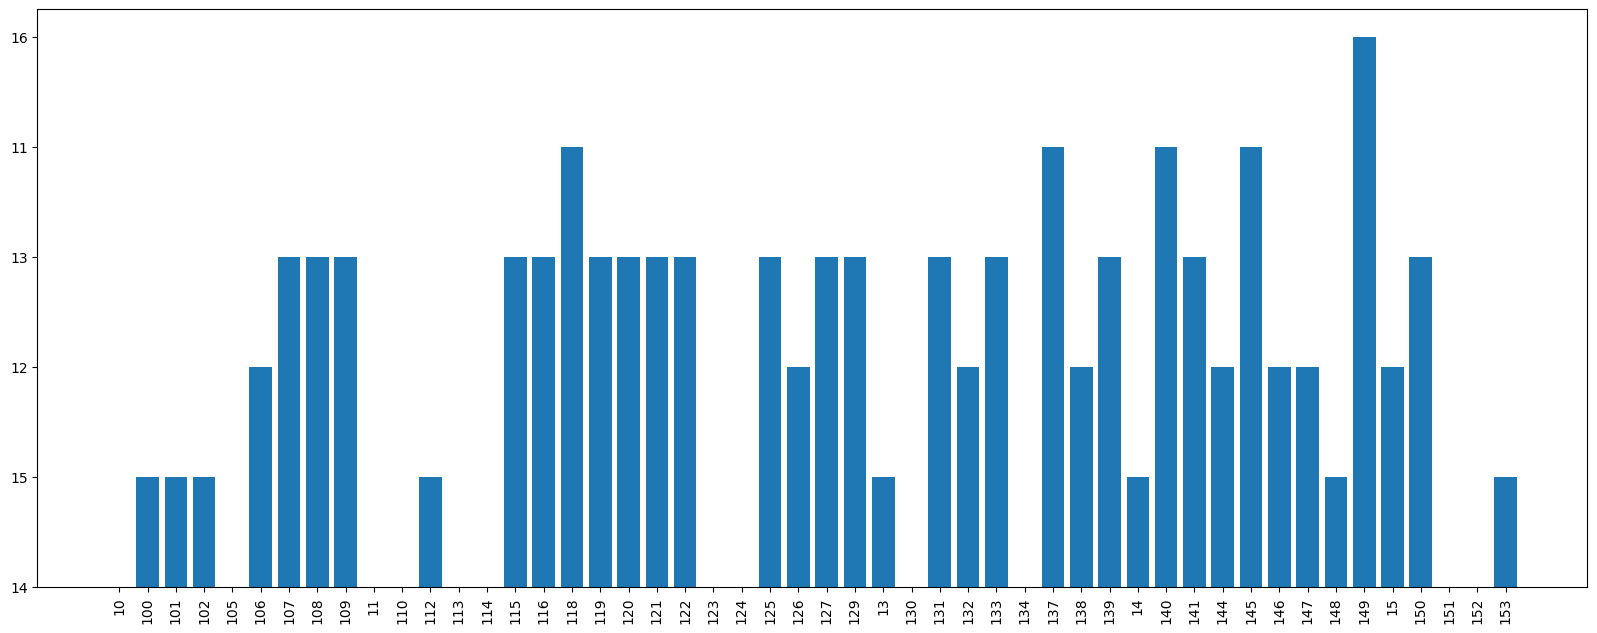

In [403]:
plt.figure(figsize=(20,7.5))
plt.bar(DF['start_stations'].head(50), DF['average_hours'].head(50))
plt.xticks(rotation=90)
plt.show()

In [364]:
DF[DF['start_stations'] == '125']

,start_stations,average_hours
1,125,13


In [416]:
DF[DF['average_hours'] == '11'].count()

start_stations    19
average_hours     19
dtype: int64

#  4 -What is the ratio of payment using cc or app wallet?

In [378]:
df.printSchema()

root
 |-- index: string (nullable = true)
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- duration_in_minutes: double (nullable = true)
 |-- cost: double (nullable = true)
 |-- start_date: string (nullable = true)
 |-- start_hour: timestamp (nullable = true)
 |-- time_of_the_day: string (nu

In [425]:
df = spark.read.format('csv').option('header', 'True').load('C:/Users/mkaya/Downloads/2017-fordgobike-tripdata.csv')

In [426]:
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)



In [427]:
df = df.withColumnRenamed('pyment', 'payment_type')

In [428]:
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- payment_type: string (nullable = true)



In [446]:
credit_card_payments = df[df['payment_type'].isin('credit card')].select('payment_type').count()
app_wallet_payments = df[df['payment_type'].isin('app wallet')].select('payment_type').count()
credit_card_ratio = credit_card_payments / (credit_card_payments + app_wallet_payments)

credit_card_ratio

0.49959399653646336

#  5-What is the preferred way to pay for customers and subscriber?

In [452]:
df.groupBy('user_type', 'payment_type').count().orderBy('user_type', 'count', ascending = False).show()

+----------+------------+------+
| user_type|payment_type| count|
+----------+------------+------+
|Subscriber|  app wallet|204727|
|Subscriber| credit card|204503|
|  Customer|  app wallet| 55334|
|  Customer| credit card| 55136|
+----------+------------+------+



# 1 - What are the worst starting stations for the business?

In [6]:
import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.functions import *

import datetime
from datetime import datetime, timedelta

In [7]:
spark = SparkSession.builder.master('local[*]').appName('Week_4').getOrCreate()

In [8]:
spark

In [9]:
df = spark.read.format('csv').option('header', 'True').load('2017-fordgobike-tripdata.csv')

In [11]:
df.columns

['duration_sec',
 'start_time',
 'end_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender']

In [12]:
df.printSchema()

root
 |-- duration_sec: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)



In [15]:
df.groupBy('start_station_id').count().orderBy('count', ascending = False).show()

+----------------+-----+
|start_station_id|count|
+----------------+-----+
|              15|15187|
|               6|13664|
|              30|12546|
|              67|12055|
|              58|11960|
|              21|11334|
|              81|10956|
|               3|10142|
|              22| 9926|
|              16| 9347|
|               5| 7987|
|              17| 7649|
|              50| 6605|
|              66| 6414|
|              90| 6223|
|              23| 5980|
|              48| 5785|
|              25| 5732|
|             324| 5609|
|             182| 5558|
+----------------+-----+
only showing top 20 rows



In [50]:
from pandas import Timestamp

In [56]:
df = df.withColumn('start_time', func.to_timestamp(df['start_time'], 'yyyy-MM-dd HH:mm:ss.SSSS')).\
withColumn('end_time', func.to_timestamp(df['end_time'], 'yyyy-MM-dd HH:mm:ss.SSSS'))

In [60]:
df = df.withColumn('duration_minutes', func.round(((df['end_time'] - df['start_time']).cast('long')) / 60 , 2))

In [62]:
df = df.withColumn('revenue', func.round(df['duration_minutes'] * 0.35 , 2))

In [63]:
df.printSchema()

root
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- revenue: double (nullable = true)



In [75]:
df.groupBy('start_station_id', 'start_station_name').agg({'revenue' : 'sum'}).\
withColumn('total_revenue', func.round('sum(revenue)', 2)).\
orderBy('total_revenue', ascending = True).\
drop('sum(revenue)').\
show()

+----------------+--------------------+-------------+
|start_station_id|  start_station_name|total_revenue|
+----------------+--------------------+-------------+
|             268|Ellsworth St at R...|         2.82|
|             339|Jackson St at 11t...|         5.68|
|             292| Empire St at 1st St|        20.03|
|             294|Pierce Ave at Mar...|        40.51|
|             340|Harmon St at Adel...|        52.63|
|             237|Fruitvale BART St...|         70.7|
|             267|Derby St at Colle...|        73.36|
|             293|W St John St at G...|        76.42|
|             299|     Bestor Art Park|       105.33|
|             337|Webster St at 19t...|       171.38|
|             301|Willow St at Vine St|       199.84|
|             338|13th St at Frankl...|        234.4|
|             216|San Pablo Ave at ...|       234.46|
|             131|Dolores St at 22n...|        244.9|
|             265|Ninth St at Parke...|       277.76|
|             288|Mission St

# 2 - What type of customer should we attract to increase our revenue?

In [76]:
df.printSchema()

root
 |-- duration_sec: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- revenue: double (nullable = true)



In [83]:
df.groupBy('user_type', 'member_birth_year', 'member_gender').agg({'revenue':'sum'}).orderBy('sum(revenue)', ascending = False).show()

+----------+-----------------+-------------+------------------+
| user_type|member_birth_year|member_gender|      sum(revenue)|
+----------+-----------------+-------------+------------------+
|  Customer|             null|         null|1110665.1700000002|
|Subscriber|             1985|         Male| 65985.81000000003|
|Subscriber|             1982|         Male|59135.889999999985|
|Subscriber|             1984|         Male|          55889.19|
|Subscriber|             1988|         Male| 55795.19999999999|
|Subscriber|             1987|         Male| 54366.89000000002|
|Subscriber|             1983|         Male|53105.909999999996|
|Subscriber|             1986|         Male| 52586.86000000001|
|Subscriber|             1989|         Male|46748.989999999976|
|Subscriber|             1980|         Male| 42171.77000000001|
|Subscriber|             1981|         Male| 39461.00000000001|
|Subscriber|             1991|         Male|           39313.4|
|Subscriber|             1975|         M

In [84]:
df.groupBy('user_type', 'member_birth_year', 'member_gender').agg({'revenue':'sum'}).orderBy('sum(revenue)', ascending = True).show()

+----------+-----------------+-------------+------------------+
| user_type|member_birth_year|member_gender|      sum(revenue)|
+----------+-----------------+-------------+------------------+
|Subscriber|             1946|       Female|              2.84|
|Subscriber|             1961|        Other|              4.29|
|  Customer|             1901|         Male|              5.09|
|  Customer|             1960|        Other|               5.5|
|Subscriber|             1944|       Female|              6.35|
|  Customer|             1958|        Other|              7.78|
|  Customer|             1964|        Other|              8.03|
|Subscriber|             1911|        Other|              8.39|
|  Customer|             1900|         Male|              9.43|
|  Customer|             1934|         Male|             10.22|
|  Customer|             1957|        Other|10.329999999999998|
|  Customer|             1901|        Other|10.370000000000001|
|  Customer|             1961|        Ot

In [85]:
df.groupBy('member_gender').agg({'revenue':'sum'}).orderBy('sum(revenue)',ascending = False).show()

+-------------+------------------+
|member_gender|      sum(revenue)|
+-------------+------------------+
|         Male|1573530.7900000021|
|         null|1129278.0999999999|
|       Female| 591319.3199999998|
|        Other|          37431.06|
+-------------+------------------+



In [86]:
df.groupBy('member_birth_year').agg({'revenue':'sum'}).orderBy('sum(revenue)',ascending = False).show()

+-----------------+------------------+
|member_birth_year|      sum(revenue)|
+-----------------+------------------+
|             null|        1129815.45|
|             1987|118012.13000000002|
|             1985|115359.60999999999|
|             1988| 103050.2800000001|
|             1982| 96167.28000000004|
|             1986| 95738.18999999999|
|             1984| 95327.69999999997|
|             1983|          90454.41|
|             1989| 89464.04000000005|
|             1990|          86062.25|
|             1991| 76758.10000000002|
|             1980|          71545.36|
|             1981|          70904.18|
|             1992| 66489.86000000002|
|             1993| 62918.08000000001|
|             1975| 56164.21000000001|
|             1979| 55250.36000000002|
|             1977| 53776.43000000001|
|             1994| 53523.82000000001|
|             1978| 48094.99999999998|
+-----------------+------------------+
only showing top 20 rows



In [87]:
df.groupBy('member_birth_year').agg({'revenue':'sum'}).orderBy('sum(revenue)',ascending = True).show()

+-----------------+------------------+
|member_birth_year|      sum(revenue)|
+-----------------+------------------+
|             1901|             15.46|
|             1886|             25.16|
|             1911|             49.86|
|             1928|             74.29|
|             1934|124.50999999999999|
|             1938|            130.63|
|             1933|            177.77|
|             1940|181.89999999999998|
|             1939|            190.09|
|             1935|211.41999999999996|
|             1924|            286.49|
|             1942|            314.01|
|             1907|            331.61|
|             1943|            557.66|
|             1941|            635.69|
|             1902| 674.1600000000001|
|             1900| 722.9200000000001|
|             1946|1400.4299999999996|
|             1945|1451.3899999999999|
|             1944|1535.2399999999998|
+-----------------+------------------+
only showing top 20 rows



In [88]:
df.groupBy('user_type').agg({'revenue':'sum'}).orderBy('sum(revenue)',ascending = True).show()

+----------+------------------+
| user_type|      sum(revenue)|
+----------+------------------+
|  Customer|1647876.9500000007|
|Subscriber|1683682.3200000015|
+----------+------------------+

